<a href="https://colab.research.google.com/github/jyj0607040607/AIStudy24/blob/master/%EC%9D%B8%EA%B3%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MBC 마켓에서 이번엔 렄키백을 패션분야에 접목을 시키려고 한다.

패션 분야이기 때문에 상품 개수가 늘어나고 어종이 아닌 일반 잡화용으로 제공하기로 하였다.

*  딥러닝의 시작 인공 신경망
*  MNIST 데이터 셋 : 손으로 쓴 0 ~ 9까지의 숫자로 이루어져 있다.
*  패션 MNIST 데이터 셋 : 숫자대신 패션 아이템으로 이루어진다.
*  실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만든다.

In [29]:
import tensorflow as tf  # 텐서플로

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용한다.

# 케라스 패키지 임포트
#케라스 패키지 임포트
from tensorflow import keras

# load_data()가 훈련세트와 테스트세트로 데이터를 나누어 반환 (input과 target의 쌍으로 이루어짐)
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

In [30]:
print(train_input.shape, train_target.shape)    # 전달받은 데이터의 크기를 확인한다.
# 트레이닝 세트(6만개, 28 가로, 28 세로) -> (타킷 6만개 1차원 배열)
# 해상도 28 X 28 픽셀

(60000, 28, 28) (60000,)


In [31]:
print(test_input.shape, test_target.shape)
# 테스트 세트(만개, 28 가로, 28 세로) -> (타킷 만개 1차원배열)

(10000, 28, 28) (10000,)


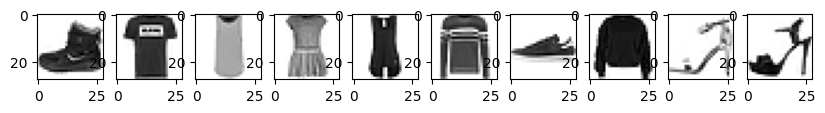

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    axs[i].imshow(train_input[i], cmap='gray_r')
    axs[i].axis('on')
plt.show()

In [33]:
print([train_target[i] for i in range(10)])   # 샘플 타깃 확인
# 0 ~ 9까지 타킷이 있다.
# 0 티셔츠, 1 바지, 2 스웨터, 3 드레스, 4 코트, 5 샌들, 6 셔츠, 7 스니커즈, 8 가방, 9 앵클부츠

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


In [34]:
import numpy as np

print(np.unique(train_target, return_counts=True))
# 10개를 배열에 정확히 6000개씩 샘플이 들어있다.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


로지스틱 회귀로 패션 아이템 분류하기

*   6만개 전체를 한번에 훈련하는 것보다 샘플 1개씩 꺼내서 모델을 훈련해보자
*   (확률적 경사 하강법 : SGDClassifier) -> 분류용
*   SGDClassifier를 사용할 때 표준화 전처리된 데이터를 사용한다.
*   확률적 경사 하강법은 여러 특성 중 기울기가 가장 가파른 방향을 따라 이동한다.
*   만약 특성마다 값의 범위가 많이 다르면 올바르게 손실함수의 경사를 내려올수 없다.
*    패션 MNIST의 경우 흑백이기에 0 ~ 255 사이의 정수값을 가진다. -> 255로 나누어 0 ~ 1 사이값이로 정규화진행한다. ( 양수값으로 이루어진 이미지 전처리용)


In [35]:
# reshape로 2차원 배열을 1차원 배열로 펼친다.
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)    # -1은 모든값
print(train_scaled.shape)
# SGDClassifier는 2차원 지원 안함

(60000, 784)


In [36]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss='log_loss', max_iter=5, random_state=42)
# max_iter 5번 반복, cross_validate 교차 검증
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print(np.mean(scores['test_score'])) #5번 반복에 대한 테스트 평균

0.8194166666666666


로지스틱 회귀

*    z = a * (Weight) + b * (Length) + c * (Diagonal) + d * (Height) + e * (Width) + f 4장용

선형방정식

*    z_티셔츠 = a * (픽셀1) + b * (픽셀2) + c * (픽셀3) + d * (픽셀4) ......... + e * (픽셀784) + f(절편)

바지에 대한 출력은 티셔프와 다른 값을 사용해야된다.(티셔츠와 다르다.)

*     z_바지 = a1 * (픽셀1) + b1 * (픽셀2) + c1 * (픽셀3) + d1 * (픽셀4) ......... + e1 * (픽셀784) + f(절편)

나머지 클래스에 대한 선형 방정식도 동일 -> 10개의 클래스에 대한 선형 방정식을 모두 계산한다.
 다음 단계인 소프트맥스 함수를 통과하여 각 클래스에 대한 확률을 얻을 수 있다.

인공 신경망 (artificial 아티피셜 neural 뉴럴 network, ANN)을 사용하여 패션 아이템 분류 문제의 성능을 높혀 보자.

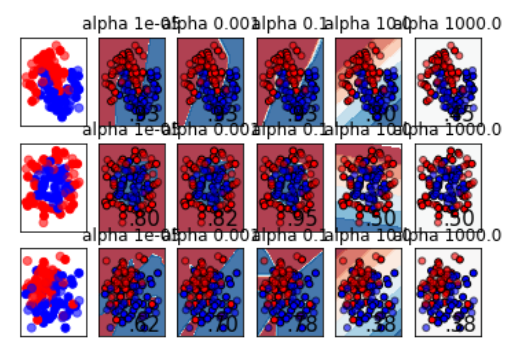


z_티셔츠 ~ 클래스 10개인 z_10까지 계싼하고 이를 바탕으로 클래스를 예측하기 떄문이다

인공신경망의 z 값 계산하는 단위는 뉴런(Neuron)이라고 부른다.
*   선형계산을 진행
*   대부분 유닛이라고 부른다.

픽셀 1 ~ 874번 픽셀까지를 입력층 (input layer) 이라고 부른다.

*   z_1를 만들기 위해서 픽셀인 x_1에 곱해지는 가중치는 w_1.1.... 10개의 뉴런이다.

사람 뇌에 있는 뉴런과 다르다.
*   무언가를 만들어내는 것이 아니라 알고리즘의 일종이다.

확률적 경사 하강법을 사용한 로지스틱 회귀 모델이 가장 간단한 인공 신경망이라면 인동 신경망을 만들어도 성능이 좋아지지 않는다.



딥러닝 라이브러리에서 인기 높은 텐서플로를 사용해보자.

*   텐서플로(TensorFlow)는 구글이 2015년 11월 오픈소스로 공개한 딥러닝 라이브러리이다.
*    -> 알파고 시절 (이세돌 1승)
*    텐서플로우 2.x 버전이 2019년 9월에 릴리스 되었다.

딥러닝 라이브러리는 GPU(그래픽카드)사용하여 인공 신경망을 훈련한다.
*   GPU는 백터와 행렬 연산으로 3D연산에 최적화 되어 있다.

곰샘과 덧샘이 많이 수행되는 인공신경망에 속도를 높여준다.

케라스 라이브러리는 직접 GPU 연산을 수행하지 않는다.

대신 GPU 연산을 수행하는 다른 라이브러리를 백엔드로 사용한다.

텐서폴로가 케라스 백엔드로 사용할 수 있다.
*   멀티 - 백엔드 케라스라고 부른다.

케라스 API만 익히면 다양한 딥러닝 라이브러리를 입맛대로 골라서 사용할수 있다.
*   직접적이고 사용하기 편하다.

In [37]:
import tensorflow as tf

from tensorflow import keras      # 케라스 : 고수준 api

인공 신경망으로 모델 만들기

*   앞에서 만든 train_scaled, train_target을 사용한다.
*   인공 신경망에서는 교차 검증을 사용하지 않고 검증 세트를 별도로 덜어내어 사용한다.
1.   딥러닝 분야의 데이터 셋은 충분히 크기 때문에 검증 점수가 안정적이다.
2.   교차 검증을 수행하기에는 훈련시간이 너무 오래 걸린다, -> plt시간이 몇시간, 며칠이 걸릴수도 있다.




In [38]:
from sklearn.model_selection import train_test_split

#  train_scaled(트레이닝 스케일), val_scaled(값 스케일 = 검증 세트 20%). train_target(트레이닝 타켓), val_target(값 타켓=검증 세트 20%)
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

print(train_scaled.shape, train_target.shape) # 훈련 세트 48,000 +
print(val_scaled.shape, val_target.shape) # 검증 세트     12,000 = 600000

(48000, 784) (48000,)
(12000, 784) (12000,)


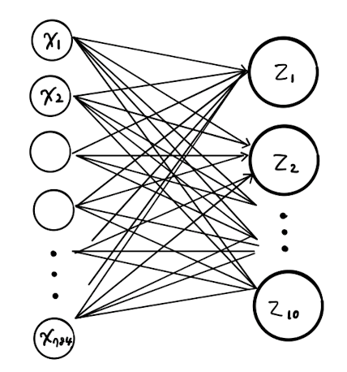

딥러닝에서는 다양한 종류의 층을 추가하는 식으로 모델을 만든다.

이번 장에서는 Dense 층을 사용, 밀집층, 완전연결층, fully connteced layer

*   10개의 유닛
*   다중 분류이므로 활성화 함수는 소프트 맥스, 입력값은 784개의 원소로 이루어진 1차원 배열.
*   이진 분류이면 시그모이드 함수를 사용한다.

*   케라스는 첫번째 층에 입력 크기를 넣어야 합니다.

그다음에 추가되는 층은 자동으로 계산되기 떄문에 넣을 필요 없습니다.

*   케하스 모델은 Sequential 클래스로 만듭니다.

*   인공신경망의 오른쪽에 놓은 층을 만듭니다.

10개의 패션아이템을 분류하기 위해서 10개의 뉴런으로 구성

*    케라스의 레이어 패키지 안에는 다양한 층이 존재한다.

*    가장 기본이 되는 층이 밀집층(dense layer)

*   밀집층(dense layer) : 784개의 픽셀과 10개의 뉴런이 모두 연결된 선이라고 뜻한다.

이런 층을 뉴런이 모두 연결하고 있어 완전 연결층(fully connected layer)라고 부른다.

In [39]:
dense = keras.layers.Dense(10, activation='softmax', input_shape=(784,))
#                            뉴런개수, 뉴런에 적용할 함수, 입력의 크기
# activation='scftmax' 출력되는 값을 확율로 바꾼다.
# activation='sigmoid' 이진분류
# 입력의 크기는 10개의 뉴런이 각각 몇개 입력을 받는지 튜플로 지정한다.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# 이제 밀집층을 가진 신경망 모델을 만들자
model = keras.Sequential([dense])
# 밀집층을 가진 신경망 모델을 만든다. Sequential (순차적구조) 클래스를 사용한다.
#  Sequential 클래스의 객체를 만들 때 앞에서 만든 밀집층의 객체 dense를 전달한다.
# 여기서 만든 model  객체가 바로 신경망 모델이다.

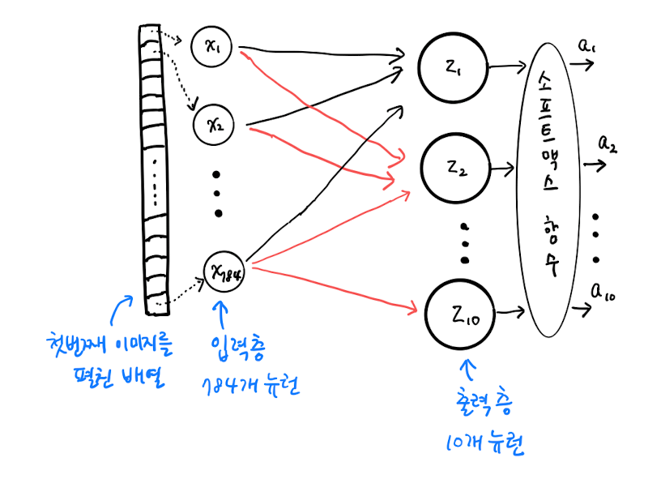

In [42]:
# 소프트맥스와 같이 뉴런의 선형 방정식 계산 결과에 적용되는 함수를 활성화 함수라고 한다.
# 위 그림을 보면 a 표시 되어있다.

# 인공 신경망으로 패션 아이템 분류하기
# 케라스 모델 훈련전 설정 단계
# nodel 객체의 complie() 메서드에서 수행
# 손실함수 loss='sparse_categorical_crossntropy' (히소 다중분류 손실 함수) -> 정수 타깃
#               'sparse_binary_crossntropy' (히소 이진분휴 손실 함수) -> 이진 타깃
# 측정값 metrics=['accuracy'] -> 정확도 (에큐러시)의 지표가 된다.
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 케라스는 자동으로 에포크마다 손실을 기록한다. -> (추가로 정확도를 기록하기 위해 metrics)

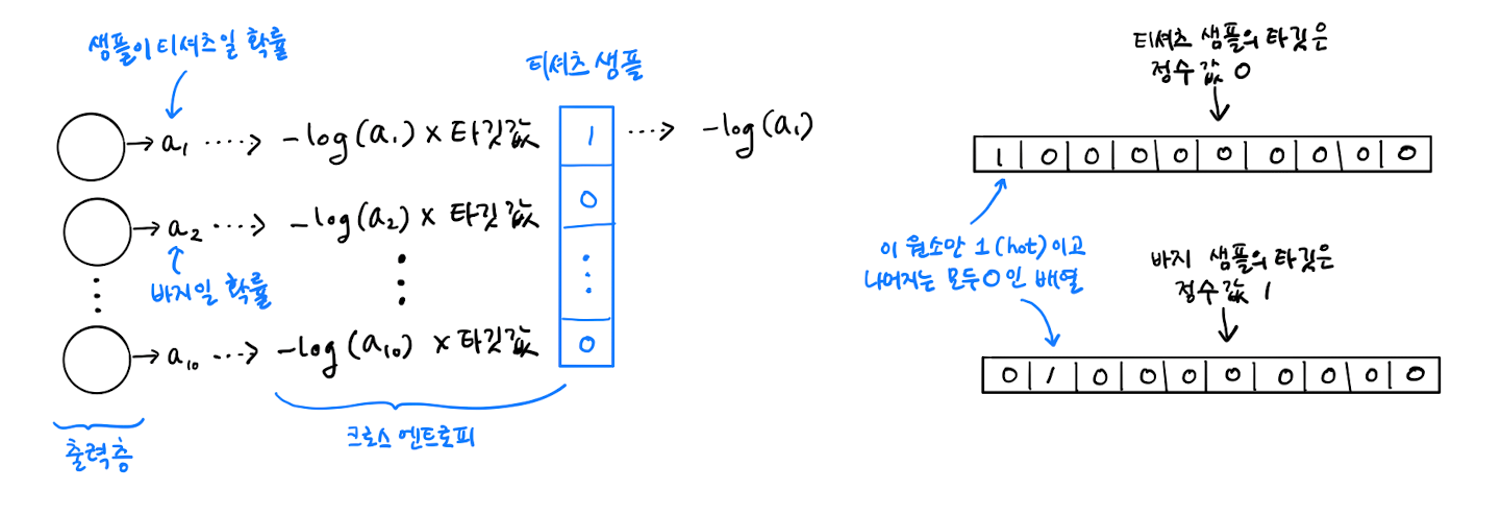

In [44]:
print(train_target[:10])    # 정수형으로 타킷 생성되어 있다 -> 원-핫 인코딩

[7 3 5 8 6 9 3 3 9 9]


In [45]:
model.fit(train_scaled, train_target, epochs=5)   # 훈련시작 (에포크 5로 5번 훈련중이다..)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7370 - loss: 0.7853
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8346 - loss: 0.4845
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8452 - loss: 0.4564
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8504 - loss: 0.4425
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8537 - loss: 0.4337


In [47]:
# 에포크마다 걸린시간, 정확도(accuracy), 손실(loss)
# 0.8537 높은 점수를 받는다.

# 케라스 모델의 성능 평가 하는 메서드 evaluate(이밸류에이트)
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8462 - loss: 0.4364


[0.4444445073604584, 0.8458333611488342]

In [ ]:
# 사이킷런과 케라스 모델 비교

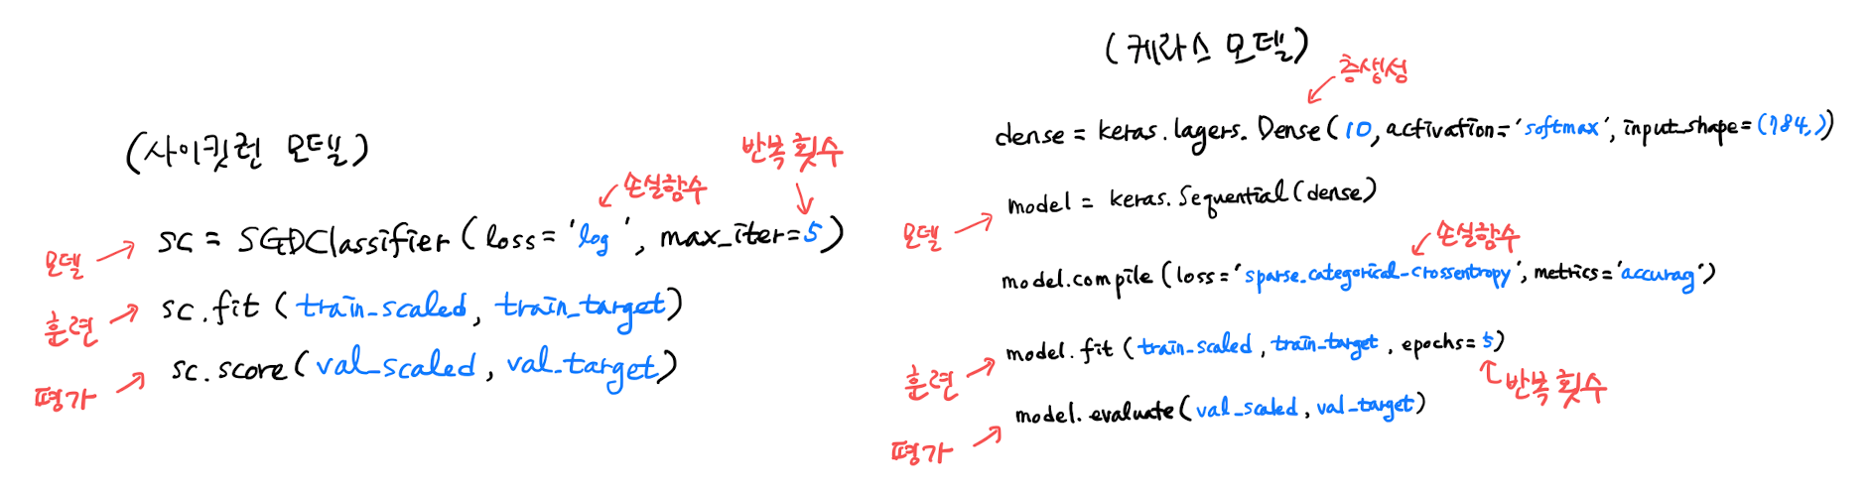